<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github.com/Doometnick/ConvNet-Workflow/blob/master/cifar10_conv2D_simple.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# A simple convolutional neural network
We will build a simple convolutional network to classify images of the CIFAR-10 dataset. 

By evaluating the results and the dynamics of the training process, we will identify the weaknesses of the model and improve them in a second session.

In [0]:
import keras
import tensorflow as tf

import functools
import matplotlib.pyplot as plt
import numpy as np
import os

Using a GPU increases the trainig speed by a significant amount. To enable it, click on *Runtime* on the top left of the site, then on *Change runtime type*. Enable GPU as a hardware accelerator.

In [0]:
assert tf.test.is_gpu_available(), "GPU not enabled"

# Data Gathering and Inspection
Now let's import the cifar10 data, which is a collection of 2D images. 
Information about the data and how to download it using tensorflow can be found on the [keras homepage](https://keras.io/datasets/).

The data is returned as two tuples, one for the training and one for the test data. Using tuple unpacking, we can directly assign them to variables.

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

Inspect the data to get an understanding of how it looks like and how we can work with it.

First let's plot a random set of 25 images and their labels together. 

In [0]:
def plot_images(images, labels):

    width, height = 5, 5
    labels = np.squeeze(labels)
    
    random_idx = np.random.choice(np.arange(images.shape[0]), width * height)
    images = images[random_idx]
    labels = labels[random_idx]
    
    class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                            'dog', 'frog', 'horse', 'ship', 'truck'])

    plt.figure(figsize=(10,10))

    for idx in range(width * height):
        plt.subplot(width, height, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[idx]], color="white")
    plt.show()


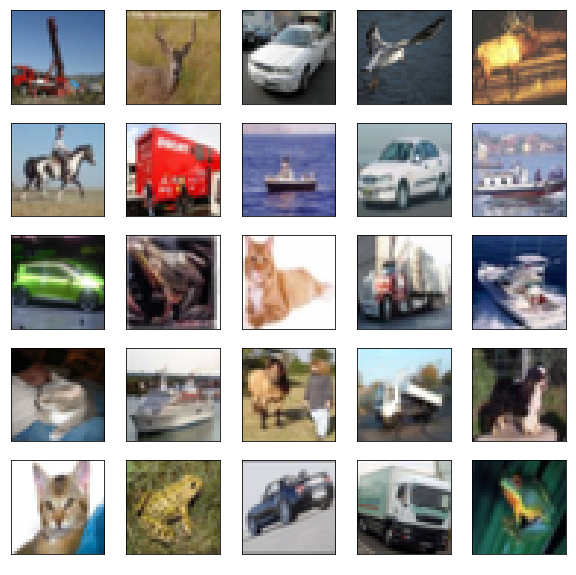

In [38]:
plot_images(x_train, y_train)

Then let's have a look at the data itself. How is it shaped, what are min and max values, and print out a subset.

In [39]:
print("### Feature data:")
print(f"Shape: {x_train.shape}")
print(f"(min, max): ({np.min(x_train)}, {np.max(x_train)})")
print(f"First RGB element (scaled to [0,1]): \n{x_train[0][0][0]}")

print("\n### Label data:")
print(f"Shape: {y_train.shape}")
print(f"(min, max): ({np.min(y_train)}, {np.max(y_train)})")
print(f"First five elements: \n{y_train[:5]}")

### Feature data:
Shape: (50000, 32, 32, 3)
(min, max): (0, 255)
First RGB element (scaled to [0,1]): 
[59 62 63]

### Label data:
Shape: (50000, 1)
(min, max): (0, 9)
First five elements: 
[[6]
 [9]
 [9]
 [4]
 [1]]


**Feature data (x):** 

There are 50'000 images, each image represented by 32x32 pixels, and each individual pixel is represented by 3 RGB values (the pixel's color).

**Label data (y):** 

A list of lists containing single integer values ranging from 0 to 9, each number corresponding to an object label (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

## Data Preparation

The raw data is already in a usable format, but we still need to carry out a small adjustment: Scale the RGB values to a range between 0 and 1.

Why is this necessary?

1. Typically, the feature variables don't come in the same range and the value ranges across variables can therefore vary strongly. If models that are employed on top of the data then work with distance measures such as the Euclidean distance, the presence of narrow and wide ranges can distort results. (Note however that our pixel data does not vary in ranges and is already normalized to a range between 0 and 255)

2. Normalization of data can increase the speed of training. This is described in a recently published [paper by Google](https://arxiv.org/abs/1502.03167?context=cs). The normalization can not only be applied in the beginning, but also in between layers of a network. This is called *batch normalization* and will be covered in the next notebook where we try to increase the quality of our model.


Since we know from the previous step that all values lie between 0 and 255, we can simply divide by 255. 


You can try running the the model with and without this step to see the difference for yourself. Watch especially the maximum accuracy and the speed of learning.

In [0]:
x_train = x_train / 255.0
x_test = x_test / 255.0

# Simple Model

Which model shall we use for this problem? 

We could use a fully connected neural network and represent each pixel by a single input node. Every pixel could be converted to a grayscale measure that can be represented in one single number rather than three, and the two-dimensions width and height (32x32) would be flattened into one long vector of size (32 * 32 = 1024). This would work, but we would lose spatial information. Sometimes information is contained in an area covering multiple pixels. For example, the head of a person in a photo is shown over multiple pixel rows and columns in this photo. It is important that these pixels are interpreted together, but this would not be possible if we flattened the pixels to a vector. Therefore, using a fully connected (dense) network would not be optimal.


Convolutional neural networks preserve spatial information and therefore pose a more suited solution to our problem.

To begin, let's define a very simple convolutional network.

In [0]:
def build_model():

    n_filters = 32

    Conv2D = functools.partial(tf.keras.layers.Conv2D, activation="relu", padding="same")
    MaxPool = functools.partial(tf.keras.layers.MaxPool2D, pool_size=(2,2))
    Flatten = tf.keras.layers.Flatten
    Dense = tf.keras.layers.Dense

    model = tf.keras.Sequential([
        
        # For the first layer, the input shape has to be defined.
        # For subsequent layers, the input shape is derived automatically.
        Conv2D(filters=n_filters*1, kernel_size=(3,3), strides=(1,1), input_shape=(32, 32, 3)),
        MaxPool(),

        Conv2D(filters=n_filters*2, kernel_size=(3,3), strides=(1,1)),
        MaxPool(),

        Flatten(),
        Dense(64, activation="relu"),
        Dense(10, activation="softmax")
    ])

    return model

We start with a two convolutional layers followed by max pooling, respectively.

The convolutions are done with kernel sizes of 3, a stride of 1, and an increasing amount of filters. The _padding="same"_ command ensures that pixels at the edge of each image are not processed much less frequent in the convolution process than the other pixels.

The max pooling operation reduces the size of the feature maps by a factor of two to reduce dimensionality while preserving spatial invariance.

Rectified linear units (ReLU) are used for activations throughout the network except for the last layer. ReLUs are common in convolutional networks and set negative values in the feature maps to zero while leaving positive ones untouched. The last layer has a softmax activation since we need to identify one of the 10 output nodes as the label. Softmax will give us a probability distribution, from which we can pick the most likely node as the predicted label.

After building the model, we can print out a summary via model.summary().

In [42]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

Now we can train the model and see if it is able to correctly classify the images in the validation set x_test. 

Since we are trying to find the one out of all correct labels for every image, categorical crossentropy is chosen as a loss. Note that sparse categorical crossentropy is chosen due to the format of our labels (y_train, y_test). These are not one-hot encoded, therefore require a sparse type of the crossentropy. If we would one-hot encode the labels, the loss would change to a categorical crossentropy.

The training will be done for 20 epochs. This takes a bit of time (3-4 minutes), but will help to illustrate the flaws of our model in a later step.

In [0]:
def compile_and_train(model, epochs):

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    history = model.fit(x_train, y_train, epochs=epochs,
                        validation_data=(x_test, y_test),
                        batch_size=64)
    return history

In [44]:
history = compile_and_train(model, epochs=20)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 154us/sample - loss: 1.4570 - acc: 0.4806 - val_loss: 1.2096 - val_acc: 0.5749
Epoch 2/20
50000/50000 [==============================] - 7s 150us/sample - loss: 1.0892 - acc: 0.6205 - val_loss: 1.0348 - val_acc: 0.6415
Epoch 3/20
50000/50000 [==============================] - 7s 150us/sample - loss: 0.9616 - acc: 0.6686 - val_loss: 1.0489 - val_acc: 0.6275
Epoch 4/20
50000/50000 [==============================] - 7s 149us/sample - loss: 0.8767 - acc: 0.6944 - val_loss: 0.9169 - val_acc: 0.6799
Epoch 5/20
50000/50000 [==============================] - 8s 159us/sample - loss: 0.8142 - acc: 0.7159 - val_loss: 0.8927 - val_acc: 0.6935
Epoch 6/20
50000/50000 [==============================] - 8s 157us/sample - loss: 0.7569 - acc: 0.7374 - val_loss: 0.8721 - val_acc: 0.7006
Epoch 7/20
50000/50000 [==============================] - 8s 156us/sample - loss: 0.7125 - acc: 0.7509 - val_l

Now let's look at how the training went. This step allows us to answer the question about whether the model is flawed and if we need to further refine it.

In [0]:
def plot_training_history(history, title=None):
    fig = plt.figure(figsize=(9,9))
    plt.plot(history['acc'], label='acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    if title is not None:
        plt.suptitle(title)


10000/10000 [==============================] - 1s 112us/sample - loss: 1.2814 - acc: 0.7009


[1.281357218170166, 0.7009]

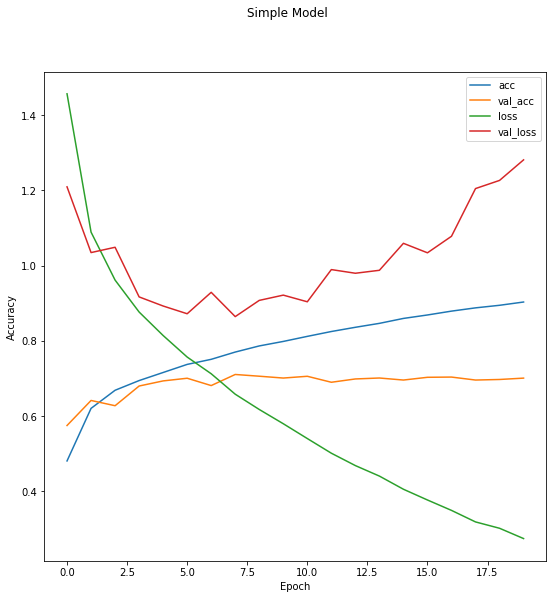

In [46]:
plot_training_history(history.history, title="Simple Model")
model.evaluate(x_test, y_test)

## Evaluation

### Observations
Looking at the chart we printed out above, the following observations can be made:
1. The **training accuracy** (_acc_) keeps increasing.
2. The **training loss** (_loss_) keeps decreasing.
3. The **validation accuracy** (_val_acc_) increase in the first couple of periods, then stagnates and even decreases again slightly.
4. The **validation loss** (_val_loss_) decreases in the first couple of periods and then starts to increase very strongly

### Interpretation
Is this good? No it is not. When training a network, we hope to see an improvement in accuracy in the training set **and** validation set. 


An increasing accuracy / decreasing loss on the training set with a simultaneous decrease in the validation set implies that the model is overfitting. Instead of learning how to classify features in pictures correctly (which should lead to an increasing accuracy in the validation set!), the network is starting to "remember" the features in the training set and settings its parameters to reduce the training loss more and more. This is a harmful development as we can see in the validation set, the loss increases.

### How to avoid overfitting
What does overfitting mean --> Memorizing the train data. So one solution is simply to add more training data.

Another option is to reduce the size of the network so less parameters can exactly fit the trainig data. However, large networks can be very powerful.

To tackle the problem of overfitting, we will add regularization to the network without changing anything else. We'll see the effects a bit further below.

# Regularized Model

**What does regularization do?**

Regularization applies an extra term to the cost function that is used to train the network. 

A quick recap of how training works can help understand regularization.

The cost function measures the distance from the desired and the obtained output of the network in a particular way, depending on the type of the cost function (for example cross-entropy cost, quadratic cost, etc.). Assuming that we have a fixed network structure that we cannot change, this difference only depends on the weights and biases of the network's nodes. In backpropagation, the weights and biases are changed relative to the cost function's sensitivity towards them - the magnitude of this change is scaled by the learning rate.

If the cost function at a given point is highly sensitive with respect to the weights, the weights might be changed strongly in order to achieve a strong reduction in cost.

This is where regularization comes in. It applies an extra term (sum of squared weights of the whole network) to the cost function. This term increases with large weights and decreases with small weights. The weight updates in backpropagation are now negatively affected by this: for larger weight updates, the penalty introduced by the regularization is higher as well and reduces the amount of the weight updates. In essence, this means that large weight updates are only carried out if the benefit of the update is large enough to offset the penalty introduced by large weights.

[Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/chap3.html#regularization) provides a a more detailed introduction to the regularization topic and its benefits.

**Regularization makes the network prefer small weights over large weights.**

There are other forms of regularization, which will be introduced later.

To build a regularized model, we can add an L2 reglarization to our network layers (Conv2D and Dense). We then train again and see the difference in results compared to the first one.

In [0]:
def build_regularized_model():

    n_filters = 32

    weight_decay = 0.0001

    Conv2D = functools.partial(tf.keras.layers.Conv2D, 
                               activation="relu", 
                               padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(weight_decay)) # regularization added
    MaxPool = functools.partial(tf.keras.layers.MaxPool2D, pool_size=(2,2))
    Flatten = tf.keras.layers.Flatten
    Dense = tf.keras.layers.Dense

    model = tf.keras.Sequential([
        
        # For the first layer, the input shape has to be defined.
        # For subsequent layers, the input shape is derived automatically.
        Conv2D(filters=n_filters*1, kernel_size=(3,3), strides=(1,1), input_shape=(32, 32, 3)),
        MaxPool(),

        Conv2D(filters=n_filters*2, kernel_size=(3,3), strides=(1,1)),
        MaxPool(),

        Flatten(),
        Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay)), # regularization oadded
        Dense(10, activation="softmax")
    ])

    return model

In [53]:
reg_model = build_regularized_model()
history_reg = compile_and_train(reg_model, 20)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 174us/sample - loss: 1.5308 - acc: 0.4532 - val_loss: 1.3114 - val_acc: 0.5452
Epoch 2/20
50000/50000 [==============================] - 8s 169us/sample - loss: 1.1764 - acc: 0.5985 - val_loss: 1.1319 - val_acc: 0.6133
Epoch 3/20
50000/50000 [==============================] - 8s 166us/sample - loss: 1.0488 - acc: 0.6447 - val_loss: 1.0370 - val_acc: 0.6475
Epoch 4/20
50000/50000 [==============================] - 8s 167us/sample - loss: 0.9718 - acc: 0.6775 - val_loss: 0.9703 - val_acc: 0.6770
Epoch 5/20
50000/50000 [==============================] - 8s 167us/sample - loss: 0.9122 - acc: 0.6986 - val_loss: 1.0021 - val_acc: 0.6666
Epoch 6/20
50000/50000 [==============================] - 9s 170us/sample - loss: 0.8704 - acc: 0.7171 - val_loss: 0.9382 - val_acc: 0.6972
Epoch 7/20
50000/50000 [==============================] - 9s 172us/sample - loss: 0.8297 - acc: 0.7328 - val_l

10000/10000 [==============================] - 1s 112us/sample - loss: 1.2814 - acc: 0.7009


[1.281357218170166, 0.7009]

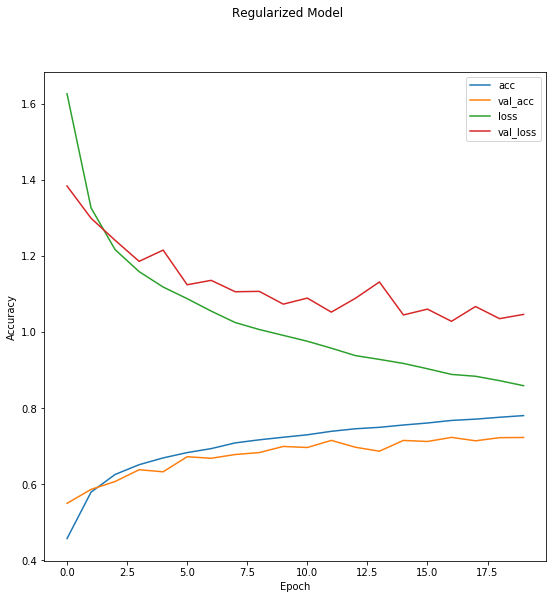

In [49]:
plot_training_history(history_reg.history, title="Regularized Model")
model.evaluate(x_test, y_test)

We can see that the training and validation accuracies and losses are very closely together. There does not seem to be any more overfitting, since an increasing loss in the training set is accompanied by an increasing loss in the validation set. This poses a much better training progress than what we saw before.

# Moving on from here

While the problem of overfitting has been taken care of, the model still performs poorly with low accuracy. Improving this is part of the second colab notebook.